### Fund holdings and Refinitiv data
* This notebook includes all the steps from constructing the final dataset to descriptive statistics for Refinitiv ESG data.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler

### Load fund and ESG data

In [2]:
fund_header = pd.read_csv('../data/fund_hdr_table.csv')
holdings_data = pd.read_csv('../data/holdings_data.csv', dtype={'maturity_dt': str})

In [3]:
fund_style_equity_only = pd.read_csv('../data/fund_style_equity_only.csv')

In [4]:
# all the funds available in database
fund_header

,cusip8,crsp_fundno,crsp_portno,crsp_cl_grp,fund_name,ticker,ncusip,first_offer_dt,mgmt_name,mgmt_cd,...,retail_fund,inst_fund,m_fund,index_fund_flag,vau_fund,et_flag,end_dt,dead_flag,delist_cd,merge_fundno
0,00036M30,1.0,NaN,2100941.0,AARP Income Trust: AARP Bond Fund for Income,AABIX,00036M307,1997-02-01,AMERICAN ASSOC OF RETIRED PERSONS,ARP,...,N,N,N,NaN,N,NaN,2000-07-31,Y,M,8441.0
1,00036W20,2.0,NaN,2000002.0,AARP Managed Investment Portfolios Trust: AARP...,AADGX,00036W206,1997-02-03,AMERICAN ASSOC OF RETIRED PERSONS,ARP,...,N,N,N,NaN,N,NaN,2000-08-31,Y,M,8425.0
2,00078H80,3.0,NaN,2000003.0,ABN AMRO Funds: International Fixed Income Fun...,AAIFX,00078H802,1993-04-26,ABN AMRO ASSET MGMT INC,ABN,...,Y,N,N,NaN,N,NaN,2000-08-31,Y,L,NaN
3,00036J60,4.0,NaN,2000004.0,AARP Growth Trust: AARP International Stock Fund,AAISX,00036J601,1997-02-03,AMERICAN ASSOC OF RETIRED PERSONS,ARP,...,N,N,N,NaN,N,NaN,2000-07-31,Y,M,8513.0
4,NaN,5.0,NaN,NaN,Active Assets Money Trust,AAMXX,NaN,1982-01-01,NaN,NaN,...,NaN,NaN,Y,NaN,N,NaN,1990-12-31,Y,L,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70708,67092P78,100143.0,NaN,2110419.0,Nushares ETF Trust: Nuveen Global Net Zero Tra...,NTZG,67092P789,2022-06-23,Nuveen Investor Services,NVN,...,N,Y,N,NaN,N,NaN,2022-06-30,N,NaN,NaN
70709,NaN,100146.0,NaN,2110420.0,Unified Series Trust: NightShares 500 ETF,NSPY,NaN,2022-06-28,NightShares,CUH,...,N,Y,N,NaN,N,NaN,2022-06-30,N,NaN,NaN
70710,NaN,100147.0,NaN,2110421.0,Unified Series Trust: NightShares 2000 ETF,NIWM,NaN,2022-06-28,NightShares,CUH,...,N,Y,N,NaN,N,NaN,2022-06-30,N,NaN,NaN
70711,47803N23,100148.0,NaN,2110422.0,John Hancock Investment Trust: John Hancock Fu...,JHFEX,47803N232,2022-06-28,John Hancock Investment Trust,BFB,...,N,Y,N,NaN,N,NaN,2022-06-30,N,NaN,NaN


### Keywords used to filter for ESG funds

In [5]:
check_list = ["SRI", "social", "ESG", "green", "sustain", "environ", "impact", "responsible", "clean", "renewable"]

In [6]:
listed_esg_fund_names = fund_header[fund_header.fund_name.str.contains('|'.join(check_list), case=False, regex=True)]

In [7]:
len(listed_esg_fund_names)

1783

In [8]:
# fund style/strategy included in research
styles = ['growth', 'income', 'small', 'mid']

In [9]:
fund_style_subset = fund_style_equity_only[fund_style_equity_only.lipper_obj_name.str.contains('|'.join(styles), case=False, regex=True)]

In [10]:
len(fund_style_subset)

61198

In [11]:
# get domestic funds with 'ED', 'ED' being equity,domestic
domestic_fund_style_subset = fund_style_subset[fund_style_subset['crsp_obj_cd'].str.contains('ED')]

In [12]:
len(domestic_fund_style_subset)

57495

In [13]:
# map fund style to fund name on crsp_fundno

In [14]:
fund_name_style_table = domestic_fund_style_subset.merge(listed_esg_fund_names, how='inner', on='crsp_fundno', validate='m:1')

In [15]:
fund_name_style_table.shape

(1319, 38)

In [16]:
fund_name_style_table

,crsp_fundno,begdt,enddt,crsp_obj_cd,si_obj_cd,accrual_fund,sales_restrict,wbrger_obj_cd,policy,lipper_class,...,retail_fund,inst_fund,m_fund,index_fund_flag,vau_fund,et_flag,end_dt,dead_flag,delist_cd,merge_fundno
0,606,31/12/1999,30/06/2000,EDYI,NaN,N,N,NaN,NaN,EIEI,...,Y,N,N,NaN,N,NaN,2000-06-30,Y,M,10747.0
1,607,31/12/1999,30/06/2000,EDYI,NaN,N,N,NaN,NaN,EIEI,...,Y,N,N,NaN,N,NaN,2000-06-30,Y,M,10748.0
2,608,31/12/1999,30/06/2000,EDYI,NaN,N,N,NaN,NaN,EIEI,...,Y,N,N,NaN,N,NaN,2000-06-30,Y,M,10749.0
3,662,31/12/1999,30/06/2000,EDYG,NaN,N,N,NaN,NaN,LCCE,...,N,Y,N,NaN,N,NaN,2000-06-30,Y,M,10687.0
4,666,31/12/1999,29/06/2000,EDCM,NaN,N,N,NaN,NaN,MCGE,...,N,Y,N,NaN,N,NaN,2000-06-30,Y,M,10483.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,99877,06/05/2022,30/06/2022,EDYB,NaN,N,N,NaN,NaN,LCVE,...,N,Y,NaN,NaN,N,NaN,2022-06-30,N,NaN,NaN
1315,99990,01/06/2022,30/06/2022,EDYG,NaN,N,N,NaN,NaN,MLCE,...,Y,N,NaN,NaN,N,NaN,2022-06-30,N,NaN,NaN
1316,100036,01/06/2022,30/06/2022,EDYG,NaN,N,N,NaN,NaN,LCCE,...,N,Y,NaN,D,N,F,2022-06-30,N,NaN,NaN
1317,100074,08/06/2022,30/06/2022,EDYG,NaN,N,N,NaN,NaN,MLCE,...,N,Y,N,NaN,N,NaN,2022-06-30,N,NaN,NaN


In [17]:
len(fund_name_style_table.crsp_fundno.unique())

642

### Funds with each of it's classes

In [18]:
fund_name_style_table.groupby(['crsp_fundno', 'lipper_class_name'])['lipper_class_name'].nunique().to_frame()

,,lipper_class_name
crsp_fundno,lipper_class_name,
606,Equity Income Funds,1
607,Equity Income Funds,1
608,Equity Income Funds,1
662,Large-Cap Core Funds,1
666,Mid-Cap Growth Funds,1
...,...,...
99877,Large-Cap Value Funds,1
99990,Multi-Cap Core Funds,1
100036,Large-Cap Core Funds,1


## Fund name and holdings data merged

In [19]:
fund_name_style_table = fund_name_style_table.loc[:, ['crsp_fundno', 'fund_name', 'crsp_portno', 'crsp_obj_cd', 
                                     'lipper_class_name', 'lipper_obj_name', 'lipper_asset_cd']]

In [20]:
fund_name_style_table['lipper_obj_name'] = fund_name_style_table['lipper_obj_name'].str.lower()

In [21]:
fund_name_style_table.loc[fund_name_style_table['lipper_obj_name']=='growth & income funds', 'lipper_obj_name'] = 'growth and income funds'

In [22]:
fund_name_style_table = fund_name_style_table.drop_duplicates().dropna(subset='crsp_portno')

In [23]:
fund_name_style_table.lipper_obj_name.unique()

array(['growth funds', 'growth and income funds', 'small-cap funds',
       'mid-cap funds', 'equity income funds'], dtype=object)

In [24]:
fund_name_style_table = fund_name_style_table.drop_duplicates(subset=['crsp_portno'])

In [25]:
fund_and_holdings_table = fund_name_style_table.merge(holdings_data, how='inner', on='crsp_portno')

In [26]:
#here I have 19712 unique securities

In [27]:
len(fund_and_holdings_table.security_name.unique())

19712

In [28]:
# not an ESG fund
to_drop = 'Valued Advisers Trust: Green Owl Intrinsic Value Fund'

In [29]:
fund_and_holdings_table = fund_and_holdings_table.drop(
    fund_and_holdings_table[fund_and_holdings_table['fund_name'] == to_drop].index
)

In [30]:
fund_and_holdings_table.loc[:, ['crsp_fundno', 'fund_name', 'lipper_class_name']].drop_duplicates().to_excel('active_fund_names.xlsx', index=False)

In [31]:
fund_and_holdings_table.groupby(['crsp_fundno', 'lipper_class_name'])['lipper_class_name'].nunique().to_frame()

,,lipper_class_name
crsp_fundno,lipper_class_name,
3946,Large-Cap Growth Funds,1
3955,Multi-Cap Growth Funds,1
5031,Large-Cap Core Funds,1
6718,Multi-Cap Growth Funds,1
6876,Multi-Cap Value Funds,1
...,...,...
99856,Mid-Cap Core Funds,1
99860,Mid-Cap Core Funds,1
99861,Mid-Cap Core Funds,1


In [32]:
final_fund_holdings_table_short = fund_and_holdings_table.loc[:, ['crsp_fundno', 'report_dt', 'nbr_shares', 'security_name', 'cusip', 'ticker']]

In [33]:
final_fund_holdings_table_short

,crsp_fundno,report_dt,nbr_shares,security_name,cusip,ticker
0,3946,2009/10/31,6365,APPLE INC,03783310,AAPL
1,3946,2009/10/31,38330,MICROSOFT CORP,59491810,MSFT
2,3946,2009/10/31,1370,GOOGLE INC,38259P50,GOOG
3,3946,2009/10/31,13660,WAL MART STORES INC,93114210,WMT
4,3946,2009/10/31,13250,TARGET CORP,87612E10,TGT
...,...,...,...,...,...,...
2330943,100115,2022/06/30,28,Aptiv PLC ORD,G6095L10,APTV
2330944,100115,2022/06/30,36,Ball Corp ORD,05849810,BALL
2330945,100115,2022/06/30,210,Orange SA ORD,F6866T10,ORAN
2330946,100115,2022/06/30,54,International Paper Co ORD,46014610,IP


In [34]:
final_fund_holdings_table_short['year_month'] = pd.to_datetime([x[:7] for x in final_fund_holdings_table_short.report_dt])

In [35]:
final_fund_holdings_table_short['year_month'] = final_fund_holdings_table_short['year_month'].dt.to_period('M')

In [36]:
final_fund_holdings_table_short = final_fund_holdings_table_short.drop('report_dt', axis=1)

In [37]:
final_fund_holdings_table_short

,crsp_fundno,nbr_shares,security_name,cusip,ticker,year_month
0,3946,6365,APPLE INC,03783310,AAPL,2009-10
1,3946,38330,MICROSOFT CORP,59491810,MSFT,2009-10
2,3946,1370,GOOGLE INC,38259P50,GOOG,2009-10
3,3946,13660,WAL MART STORES INC,93114210,WMT,2009-10
4,3946,13250,TARGET CORP,87612E10,TGT,2009-10
...,...,...,...,...,...,...
2330943,100115,28,Aptiv PLC ORD,G6095L10,APTV,2022-06
2330944,100115,36,Ball Corp ORD,05849810,BALL,2022-06
2330945,100115,210,Orange SA ORD,F6866T10,ORAN,2022-06
2330946,100115,54,International Paper Co ORD,46014610,IP,2022-06


### Refinitiv ESG data

In [38]:
refinitiv_data = pd.read_csv("../data/refinitiv_required_sample.csv")

In [39]:
len(refinitiv_data)

566126

### Load input which maps cusip to isin

In [40]:
sec = pd.read_csv(r"C:\Users\johnd\PycharmProjects\pythonproject\Basecamp\sec_header.csv")

In [41]:
sec = sec.drop_duplicates(subset='scusip')

In [42]:
sec

,scusip,tic,isin
0,000032102,AE.2,NaN
1,000165100,AMFD.,US0001651001
2,000354100,ANTQ,US0003541002
3,000361105,AIR,US0003611052
4,000781104,ABSI.1,US0007811047
...,...,...,...
47450,67013H114,NOW.WT,CA67013H1148
47451,37428A103,GET,US37428A1034
47452,74907L102,QNRX,US74907L1026
47453,67578E100,ODDAF,CA67578E1007


In [43]:
final_fund_holdings_table_short.cusip.drop_duplicates().dropna().to_excel('cusip_8.xlsx', index=False)

In [44]:
cusip_9_digit = pd.read_csv('../data/cusip_9_overall_redone.csv')

In [45]:
cusip_9_digit = cusip_9_digit.rename(columns={'cusip':'cusip_9'})

In [46]:
cusip_9_digit['cusip_8'] = [x[:8] for x in cusip_9_digit['cusip_9']]

In [47]:
cusip_and_isins = cusip_9_digit.merge(sec, how='inner', left_on='cusip_9', right_on='scusip', validate='1:1')

In [48]:
cusip_and_isins

,cusip_9,cusip_8,scusip,tic,isin
0,000307108,00030710,000307108,AACH,US0003071083
1,000360206,00036020,000360206,AAON,US0003602069
2,000361105,00036110,000361105,AIR,US0003611052
3,000375204,00037520,000375204,ABB,US0003752047
4,000380204,00038020,000380204,ABCM,US0003802040
...,...,...,...,...,...
6594,Y8564W103,Y8564W10,Y8564W103,TK,MHY8564W1030
6595,Y8565N300,Y8565N30,Y8565N300,TNK,MHY8565N3002
6596,Y8897Y180,Y8897Y18,Y8897Y180,TOPS,MHY8897Y1804
6597,Y93691106,Y9369110,Y93691106,VRGY,SG9999002885


In [49]:
# merge above table with refinitiv data

In [50]:
refinitiv_isin_mapped = refinitiv_data.merge(cusip_and_isins, how='inner', on='isin', validate='m:1')

In [51]:
# we have a sample of 3230 using overall_data as compared to previous 2879 securities.

In [52]:
len(refinitiv_isin_mapped.company.drop_duplicates())

3230

In [53]:
# Non NA observations count
refinitiv_isin_mapped.notna().sum()

rater                264491
mydate               264491
isin                 264491
riccode              264491
company              264491
gics                 264491
region               264491
market               264491
total_esg_score      264491
environment_score    264479
social_score         264383
governance_score     264491
cusip_9              264491
cusip_8              264491
scusip               264491
tic                  264491
dtype: int64

In [54]:
refinitiv_isin_mapped['year_month'] = pd.to_datetime([x[:7] for x in refinitiv_isin_mapped.mydate])

In [55]:
refinitiv_isin_mapped['year_month'] = refinitiv_isin_mapped['year_month'].dt.to_period('M')

In [56]:
companies_in_both_frames = (final_fund_holdings_table_short.drop_duplicates(subset='cusip').merge(refinitiv_isin_mapped.drop_duplicates(subset='isin'),
                                                                      left_on='cusip', right_on='cusip_8', validate='1:1'))

In [57]:
# I used the cusips from the combined table to identify 3230 securities in fund table

In [58]:
required_fund_holdings_table = final_fund_holdings_table_short.set_index('cusip').loc[companies_in_both_frames['cusip']]

In [59]:
required_fund_holdings_table = required_fund_holdings_table.reset_index().sort_values(['crsp_fundno', 'cusip'])

In [60]:
required_fund_holdings_table

,cusip,crsp_fundno,nbr_shares,security_name,ticker,year_month
52878,00282410,3946,7800,ABBOTT LABORATORIES,ABT,2009-10
52879,00282410,3946,8450,ABBOTT LABORATORIES,ABT,2010-01
52880,00282410,3946,9345,ABBOTT LABORATORIES,ABT,2010-04
52881,00282410,3946,9345,ABBOTT LABORATORIES,ABT,2010-06
52882,00282410,3946,9345,ABBOTT LABORATORIES,ABT,2010-07
...,...,...,...,...,...,...
341025,G6095L10,100115,28,Aptiv PLC ORD,APTV,2022-06
1452985,H0130112,100115,74,Alcon AG ORD,ALCC,2022-06
1640807,H3238Q10,100115,2,Givaudan SA ORD,GIVN,2022-06
1641167,H4209710,100115,434,UBS Group AG ORD,UBSG,2022-06


### Drop negative number of shares

In [61]:
required_fund_holdings_table = required_fund_holdings_table[~required_fund_holdings_table.nbr_shares<0]

In [62]:
required_refinitiv_isin_mapped = refinitiv_isin_mapped.loc[:, ['year_month','cusip_8', 'total_esg_score', 'environment_score', 
                                                           'social_score', 'governance_score']].sort_values(['cusip_8', 'year_month'])

In [63]:
agg_holdings = required_fund_holdings_table.groupby(['cusip', 'year_month'])['nbr_shares'].sum().to_frame().reset_index()

In [64]:
agg_holdings

,cusip,year_month,nbr_shares
0,00036020,2009-10,400
1,00036020,2010-01,400
2,00036020,2010-04,900
3,00036020,2010-07,1500
4,00036020,2010-10,1100
...,...,...,...
263233,Y8565N30,2021-04,3398
263234,Y8565N30,2021-07,11235
263235,Y8565N30,2021-10,9449
263236,Y8565N30,2022-01,9449


In [65]:
# these cusips have just one observation
for x in agg_holdings['cusip'].drop_duplicates():
    table_1 = agg_holdings.set_index('cusip').loc[x]
    if type(table_1) == pd.core.series.Series:
        print(x)

00507W20
00511110
02155H20
04746L10
05614L20
07134L10
12674W10
21037X10
25525P10
30263520
33833X10
34991510
37654910
38046W10
38101310
39533010
44934S20
45256X10
45303840
45320410
48138M10
48253L20
52490G10
53960E10
55270410
57055L10
72814P10
73730P10
89142B10
89346D10
92534K10
96684W10
98422E10
B639CJ10
G0694010
Y2187A15


In [66]:
len([x for x in agg_holdings['cusip'].drop_duplicates()])

3229

In [67]:
%%time
nbr_shares_esg_time_series = []
for x in agg_holdings['cusip'].drop_duplicates():
    table_1 = agg_holdings.set_index('cusip').loc[x]
    if type(table_1) != pd.core.series.Series:
        table_1 = table_1.drop_duplicates(subset='year_month').reset_index().set_index('year_month').resample('M').ffill()
        nbr_shares_esg_time_series.append(table_1)
    print('completed',len(nbr_shares_esg_time_series))

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10
completed 11
completed 12
completed 13
completed 14
completed 15
completed 16
completed 17
completed 18
completed 19
completed 20
completed 21
completed 22
completed 23
completed 24
completed 25
completed 26
completed 27
completed 28
completed 29
completed 30
completed 31
completed 32
completed 33
completed 34
completed 35
completed 36
completed 37
completed 38
completed 39
completed 40
completed 41
completed 42
completed 43
completed 44
completed 45
completed 46
completed 47
completed 48
completed 49
completed 50
completed 50
completed 51
completed 52
completed 52
completed 53
completed 54
completed 55
completed 56
completed 57
completed 58
completed 59
completed 60
completed 61
completed 62
completed 63
completed 64
completed 65
completed 66
completed 67
completed 68
completed 69
completed 70
completed 71
completed 72
completed 73
completed 74
completed 75
complete

completed 590
completed 591
completed 592
completed 593
completed 594
completed 595
completed 596
completed 597
completed 598
completed 599
completed 600
completed 601
completed 602
completed 603
completed 604
completed 605
completed 606
completed 607
completed 608
completed 609
completed 610
completed 611
completed 612
completed 613
completed 614
completed 615
completed 616
completed 617
completed 618
completed 619
completed 620
completed 621
completed 622
completed 623
completed 624
completed 625
completed 626
completed 627
completed 628
completed 629
completed 630
completed 631
completed 632
completed 633
completed 634
completed 635
completed 636
completed 637
completed 638
completed 639
completed 640
completed 641
completed 642
completed 643
completed 644
completed 645
completed 646
completed 647
completed 648
completed 649
completed 650
completed 651
completed 652
completed 653
completed 654
completed 655
completed 656
completed 657
completed 658
completed 659
completed 660
comple

completed 1160
completed 1161
completed 1162
completed 1163
completed 1164
completed 1165
completed 1166
completed 1167
completed 1168
completed 1169
completed 1170
completed 1171
completed 1172
completed 1173
completed 1174
completed 1175
completed 1176
completed 1177
completed 1178
completed 1179
completed 1180
completed 1181
completed 1182
completed 1183
completed 1184
completed 1185
completed 1186
completed 1187
completed 1188
completed 1189
completed 1190
completed 1191
completed 1192
completed 1193
completed 1194
completed 1195
completed 1196
completed 1197
completed 1198
completed 1199
completed 1200
completed 1201
completed 1202
completed 1203
completed 1204
completed 1205
completed 1206
completed 1207
completed 1208
completed 1209
completed 1210
completed 1211
completed 1212
completed 1213
completed 1214
completed 1215
completed 1216
completed 1217
completed 1218
completed 1219
completed 1220
completed 1221
completed 1222
completed 1223
completed 1224
completed 1225
completed 

completed 1696
completed 1697
completed 1698
completed 1699
completed 1700
completed 1701
completed 1702
completed 1703
completed 1704
completed 1705
completed 1706
completed 1707
completed 1707
completed 1708
completed 1709
completed 1710
completed 1711
completed 1712
completed 1713
completed 1714
completed 1715
completed 1716
completed 1717
completed 1718
completed 1719
completed 1720
completed 1721
completed 1722
completed 1723
completed 1724
completed 1725
completed 1726
completed 1727
completed 1728
completed 1729
completed 1730
completed 1731
completed 1732
completed 1733
completed 1734
completed 1735
completed 1736
completed 1737
completed 1738
completed 1739
completed 1740
completed 1741
completed 1742
completed 1743
completed 1744
completed 1745
completed 1746
completed 1747
completed 1748
completed 1749
completed 1750
completed 1751
completed 1752
completed 1753
completed 1754
completed 1755
completed 1756
completed 1757
completed 1758
completed 1759
completed 1760
completed 

completed 2240
completed 2241
completed 2242
completed 2243
completed 2244
completed 2245
completed 2246
completed 2247
completed 2248
completed 2249
completed 2250
completed 2251
completed 2252
completed 2253
completed 2254
completed 2255
completed 2256
completed 2257
completed 2258
completed 2259
completed 2260
completed 2261
completed 2262
completed 2263
completed 2264
completed 2265
completed 2266
completed 2267
completed 2268
completed 2269
completed 2270
completed 2271
completed 2272
completed 2273
completed 2274
completed 2275
completed 2276
completed 2277
completed 2278
completed 2279
completed 2280
completed 2281
completed 2282
completed 2283
completed 2284
completed 2285
completed 2286
completed 2287
completed 2288
completed 2289
completed 2290
completed 2291
completed 2292
completed 2293
completed 2294
completed 2295
completed 2296
completed 2297
completed 2298
completed 2299
completed 2300
completed 2301
completed 2302
completed 2303
completed 2304
completed 2305
completed 

completed 2785
completed 2786
completed 2787
completed 2788
completed 2789
completed 2790
completed 2791
completed 2792
completed 2793
completed 2794
completed 2795
completed 2796
completed 2797
completed 2798
completed 2799
completed 2800
completed 2801
completed 2802
completed 2803
completed 2804
completed 2805
completed 2806
completed 2807
completed 2808
completed 2809
completed 2810
completed 2811
completed 2812
completed 2813
completed 2814
completed 2815
completed 2816
completed 2817
completed 2818
completed 2819
completed 2820
completed 2821
completed 2822
completed 2823
completed 2824
completed 2825
completed 2826
completed 2827
completed 2828
completed 2829
completed 2830
completed 2831
completed 2832
completed 2833
completed 2834
completed 2835
completed 2836
completed 2837
completed 2838
completed 2839
completed 2840
completed 2841
completed 2842
completed 2843
completed 2844
completed 2845
completed 2846
completed 2847
completed 2848
completed 2849
completed 2850
completed 

In [68]:
len(nbr_shares_esg_time_series)

3193

In [69]:
agg_holdings = pd.concat(nbr_shares_esg_time_series).reset_index()

In [70]:
required_refinitiv_isin_mapped = required_refinitiv_isin_mapped.groupby(['cusip_8', 'year_month']).value_counts().to_frame().drop(0, axis=1).reset_index()

In [71]:
required_refinitiv_isin_mapped

,cusip_8,year_month,total_esg_score,environment_score,social_score,governance_score
0,00036020,2015-01,17.15,0.0,27.61,24.02
1,00036020,2015-02,17.15,0.0,27.61,24.02
2,00036020,2015-03,17.15,0.0,27.61,24.02
3,00036020,2015-04,17.15,0.0,27.61,24.02
4,00036020,2015-05,17.15,0.0,27.61,24.02
...,...,...,...,...,...,...
264378,Y8565N30,2021-08,43.27,55.9,44.79,26.38
264379,Y8565N30,2021-09,43.27,55.9,44.79,26.38
264380,Y8565N30,2021-10,43.27,55.9,44.79,26.38
264381,Y8565N30,2021-11,43.27,55.9,44.79,26.38


In [72]:
final_table_for_stata = agg_holdings.merge(required_refinitiv_isin_mapped, how='inner', left_on=['cusip', 'year_month'], right_on=['cusip_8', 'year_month'], validate='1:1')

In [73]:
final_table_for_stata.cusip.drop_duplicates().to_excel('cusip_for_monthly_stock_data_refinitiv.xlsx', index=False)

### Import shares outstanding

In [74]:
shrout = pd.read_csv('../data/shrout_total_ret.csv')

In [75]:
shrout

,HdrCUSIP,CUSIP,CUSIP9,SecurityNm,SecurityActiveFlg,Ticker,MthCalDt,MthRet,ShrOut
0,46603210,46603210,466032109,J & J SNACK FOODS CORP; COM NONE; CONS,Y,JJSF,2009/06/30,-0.040653,18433.0
1,46603210,46603210,466032109,J & J SNACK FOODS CORP; COM NONE; CONS,Y,JJSF,2009/07/31,0.207242,18446.0
2,46603210,46603210,466032109,J & J SNACK FOODS CORP; COM NONE; CONS,Y,JJSF,2009/08/31,0.008306,18446.0
3,46603210,46603210,466032109,J & J SNACK FOODS CORP; COM NONE; CONS,Y,JJSF,2009/09/30,-0.009459,18526.0
4,46603210,46603210,466032109,J & J SNACK FOODS CORP; COM NONE; CONS,Y,JJSF,2009/10/30,-0.093077,18526.0
...,...,...,...,...,...,...,...,...,...
348575,88160R10,88160R10,88160R101,TESLA INC; COM NONE; CONS,Y,TSLA,2021/08/31,0.070605,1001767.0
348576,88160R10,88160R10,88160R101,TESLA INC; COM NONE; CONS,Y,TSLA,2021/09/30,0.054042,1004000.0
348577,88160R10,88160R10,88160R101,TESLA INC; COM NONE; CONS,Y,TSLA,2021/10/29,0.436530,1004265.0
348578,88160R10,88160R10,88160R101,TESLA INC; COM NONE; CONS,Y,TSLA,2021/11/30,0.027612,1004265.0


In [76]:
shrout['year_month'] = pd.to_datetime(shrout['MthCalDt'], format='%Y/%m/%d').dt.to_period('M')

In [77]:
required_shrout = shrout.loc[:, ['CUSIP', 'CUSIP9', 'year_month', 'ShrOut']]

In [78]:
required_shrout.isna().sum()

CUSIP          0
CUSIP9         0
year_month     0
ShrOut        22
dtype: int64

In [79]:
required_shrout = required_shrout.dropna(subset='ShrOut')

In [80]:
final_table_stata_and_shrout = final_table_for_stata.merge(required_shrout, how='inner', left_on=['cusip', 'year_month'], right_on=['CUSIP', 'year_month'])

In [81]:
final_table_stata_and_shrout.cusip.drop_duplicates()

0         00036020
72        00036110
144       00081T10
216       00086810
277       00090Q10
            ...   
203494    Y0436Q10
203502    Y2106R11
203562    Y2685T13
203592    Y4105310
203634    Y8565N30
Name: cusip, Length: 2886, dtype: object

### Add column for ratings based on refinitiv methodology
* Map the numerical score to it's corresponding alphabetical rating.

In [82]:
# source: https://www.refinitiv.com/content/dam/marketing/en_us/documents/methodology/refinitiv-esg-scores-methodology.pdf, page:7

def score_to_grade(score):
    if score <= 0.083333:
        return "D-"
    elif 0.083333 < score <= 0.16666:
        return "D"
    elif 0.166666 < score <= 0.25000:
        return "D+"
    elif 0.250000 < score <= 0.33333:
        return "C-"
    elif 0.333333 < score <= 0.41666:
        return "C"
    elif 0.416666 < score <= 0.50000:
        return "C+"
    elif 0.500000 < score <= 0.58333:
        return "B-"
    elif 0.583333 < score <= 0.666666:
        return "B"
    elif 0.666666 < score <= 0.75000:
        return "B+"
    elif 0.750000 < score <= 0.83333:
        return "A-"
    elif 0.833333 < score <= 0.91666:
        return "A"
    elif 0.916666 < score <= 1:
        return "A+"


In [83]:
final_table_stata_and_shrout['esg_grade'] = (final_table_stata_and_shrout['total_esg_score']/100).map(score_to_grade)

In [84]:
# source: https://stackoverflow.com/questions/48673046/get-index-where-value-changes-in-pandas-dataframe-column
changes = {}

for col in ['esg_grade']:
    changes[col] = [0] + [idx for idx, (i, j) in enumerate(zip(final_table_stata_and_shrout[col], final_table_stata_and_shrout[col][1:]), 1) if i != j]

In [85]:
# observations where esg_grade changes
esg_grade_changes = final_table_stata_and_shrout.iloc[changes['esg_grade']].copy()

In [86]:
# adding an ordered scale for the ratings to identify up and downgrades.

In [87]:
esg_grade_changes_dict_map = {'A+':12, 
                              'A':11, 
                              'A-':10,
                              'B+':9,
                             'B':8,
                             'B-':7,
                             'C+':6,
                             'C':5,
                             'C-':4,
                             'D+':3,
                             'D':2,
                             'D-':1}
final_table_stata_and_shrout['esg_grade_num'] = final_table_stata_and_shrout['esg_grade'].map(esg_grade_changes_dict_map)

In [88]:
final_table_stata_and_shrout.head()

,year_month,cusip,nbr_shares,cusip_8,total_esg_score,environment_score,social_score,governance_score,CUSIP,CUSIP9,ShrOut,esg_grade,esg_grade_num
0,2015-01,00036020,6907,00036020,17.15,0.0,27.61,24.02,00036020,000360206,54042.0,D+,3
1,2015-02,00036020,6907,00036020,17.15,0.0,27.61,24.02,00036020,000360206,54057.0,D+,3
2,2015-03,00036020,6907,00036020,17.15,0.0,27.61,24.02,00036020,000360206,54171.0,D+,3
3,2015-04,00036020,4612,00036020,17.15,0.0,27.61,24.02,00036020,000360206,54171.0,D+,3
4,2015-05,00036020,4612,00036020,17.15,0.0,27.61,24.02,00036020,000360206,54137.0,D+,3


In [89]:
# source: https://stackoverflow.com/questions/48673046/get-index-where-value-changes-in-pandas-dataframe-column
changes = {}

for col in ['esg_grade']:
    changes[col] = [0] + [idx for idx, (i, j) in enumerate(zip(final_table_stata_and_shrout[col], final_table_stata_and_shrout[col][1:]), 1) if i != j]

for col in ['esg_grade_num']:
    changes['upgrade'] = [idx for idx, (i, j) in enumerate(zip(final_table_stata_and_shrout[col], final_table_stata_and_shrout[col][1:]), 1) if i < j] 

for col in ['esg_grade_num']:
    changes['downgrade'] = [idx for idx, (i, j) in enumerate(zip(final_table_stata_and_shrout[col], final_table_stata_and_shrout[col][1:]), 1) if i > j]        

In [90]:
upgrade_frame = pd.DataFrame({x:'upgrade' for x in changes['upgrade']}, index=[0]).T
downgrade_frame = pd.DataFrame({x:'downgrade' for x in changes['downgrade']}, index=[0]).T
upgrades_and_downgrades = pd.concat([upgrade_frame,downgrade_frame]).rename(columns={0:'up_or_down'})
upgrades_and_downgrades.loc[upgrades_and_downgrades['up_or_down']=='upgrade', 'upgrade_dummy'] = 1
upgrades_and_downgrades.loc[upgrades_and_downgrades['up_or_down']=='downgrade', 'downgrade_dummy'] = 1

In [91]:
upgrades_and_downgrades['upgrade_dummy'] = upgrades_and_downgrades['upgrade_dummy'].fillna(0).astype(int)
upgrades_and_downgrades['downgrade_dummy'] = upgrades_and_downgrades['downgrade_dummy'].fillna(0).astype(int)
upgrades_and_downgrades

,up_or_down,upgrade_dummy,downgrade_dummy
48,upgrade,1,0
108,upgrade,1,0
132,upgrade,1,0
144,upgrade,1,0
168,upgrade,1,0
...,...,...,...
203300,downgrade,0,1
203331,downgrade,0,1
203494,downgrade,0,1
203502,downgrade,0,1


In [92]:
# obs where esg_grade changes
esg_grade_changes = final_table_stata_and_shrout.iloc[changes['esg_grade']].copy()

In [93]:
esg_grade_changes = pd.concat([esg_grade_changes, upgrades_and_downgrades], axis=1)

In [94]:
esg_grade_changes

,year_month,cusip,nbr_shares,cusip_8,total_esg_score,environment_score,social_score,governance_score,CUSIP,CUSIP9,ShrOut,esg_grade,esg_grade_num,up_or_down,upgrade_dummy,downgrade_dummy
0,2015-01,00036020,6907,00036020,17.15,0.00,27.61,24.02,00036020,000360206,54042.0,D+,3,NaN,NaN,NaN
48,2019-01,00036020,23678,00036020,43.29,51.83,37.13,41.11,00036020,000360206,51991.0,C+,6,upgrade,1.0,0.0
72,2015-06,00036110,312,00036110,24.89,5.00,41.16,17.42,00036110,000361105,39661.0,D+,3,downgrade,0.0,1.0
108,2018-06,00036110,20357,00036110,27.22,3.46,36.98,31.41,00036110,000361105,34639.0,C-,4,upgrade,1.0,0.0
132,2020-06,00036110,73015,00036110,45.20,29.09,54.25,44.75,00036110,000361105,35101.0,C+,6,upgrade,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203568,2019-01,Y2685T13,4464,Y2685T13,32.81,15.12,21.26,69.07,Y2685T13,Y2685T131,41547.0,C-,4,upgrade,1.0,0.0
203580,2020-01,Y2685T13,4464,Y2685T13,34.37,26.58,26.62,53.78,Y2685T13,Y2685T131,41754.0,C,5,upgrade,1.0,0.0
203592,2017-07,Y4105310,6134,Y4105310,28.94,8.35,11.67,77.50,Y4105310,Y41053102,29208.0,C-,4,downgrade,0.0,1.0
203610,2019-01,Y4105310,5977,Y4105310,36.86,16.60,27.29,74.11,Y4105310,Y41053102,29185.0,C,5,upgrade,1.0,0.0


In [95]:
# concat treatment dates into final table

In [96]:
final_table_stata_and_shrout = final_table_stata_and_shrout.drop(['CUSIP', 'CUSIP9'], axis=1)

In [97]:
final_table_stata_and_shrout['esg_ownership'] = final_table_stata_and_shrout['nbr_shares']/(final_table_stata_and_shrout['ShrOut']*1000)

In [98]:
final_table_stata_and_shrout['esg_ownership_(%)'] = final_table_stata_and_shrout['esg_ownership']*100

In [99]:
final_table_stata_and_shrout.describe().T.apply(lambda x: x.map('{:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
nbr_shares,203652.00,217639.11,653333.46,1.00,5579.00,29438.50,143145.75,26447621.00
total_esg_score,203652.00,41.94,19.16,0.21,27.14,38.76,55.50,95.15
environment_score,203652.00,27.50,28.22,0.00,0.00,18.54,49.37,98.99
social_score,203652.00,44.13,21.06,0.26,27.97,40.81,58.98,97.91
governance_score,203652.00,50.23,21.88,0.02,33.08,51.24,67.63,99.45
ShrOut,203652.00,252354.89,676490.10,207.00,37134.00,81814.00,207167.00,29206400.00
esg_grade_num,203652.00,5.53,2.31,1.00,4.00,5.00,7.00,12.00
esg_ownership,203652.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14
esg_ownership_(%),203652.00,0.10,0.26,0.00,0.01,0.04,0.10,13.97


In [100]:
esg_grade_changes = esg_grade_changes.rename(columns={'year_month': 'treatment_date', 'cusip':'cusip_grade_change'})

In [101]:
# set first month of each security as untreated.
esg_grade_changes.loc[esg_grade_changes.drop_duplicates('cusip_grade_change').index, ['up_or_down', 'upgrade_dummy', 'downgrade_dummy']] = 0

In [102]:
esg_grade_changes.loc[esg_grade_changes['up_or_down']==0, 'treatment_date']= np.nan

In [103]:
esg_grade_changes = esg_grade_changes.loc[:, ['treatment_date', 'up_or_down', 'upgrade_dummy', 'downgrade_dummy']]

In [104]:
final_table_stata_and_shrout_all_changes = pd.concat([final_table_stata_and_shrout, esg_grade_changes], axis=1)

In [105]:
first_upgrade_index = final_table_stata_and_shrout_all_changes[final_table_stata_and_shrout_all_changes['up_or_down']=='upgrade'].drop_duplicates(subset=['cusip', 'up_or_down']).index

In [106]:
first_downgrade_index = final_table_stata_and_shrout_all_changes[final_table_stata_and_shrout_all_changes['up_or_down']=='downgrade'].drop_duplicates(subset=['cusip', 'up_or_down']).index

In [107]:
first_up_and_downgrade_list = list(first_upgrade_index) + list(first_downgrade_index)

In [108]:
first_up_and_downgrade_table = esg_grade_changes.loc[first_up_and_downgrade_list]

In [109]:
final_table_stata_and_shrout = pd.concat([final_table_stata_and_shrout, first_up_and_downgrade_table], axis=1)

In [110]:
final_table_stata_and_shrout.up_or_down = final_table_stata_and_shrout.up_or_down.fillna(0)
final_table_stata_and_shrout.upgrade_dummy = final_table_stata_and_shrout.upgrade_dummy.fillna(0).astype(int)
final_table_stata_and_shrout.downgrade_dummy = final_table_stata_and_shrout.downgrade_dummy.fillna(0).astype(int)

In [111]:
# here we only look at the first upgrade and downgrades (i.e. we only consider the initial treatment for each security)
# we do not consider multiple upgrades/downgrades for same security
final_table_stata_and_shrout.groupby(['cusip'])['up_or_down'].value_counts().to_frame().head(10)

up_or_down
cusip    up_or_down            
00036020 0                   71
         upgrade              1
00036110 0                   71
         upgrade              1
00081T10 0                   70
         downgrade            1
         upgrade              1
00086810 0                   59
         downgrade            1
         upgrade              1

In [112]:
id_for_cusips_dict = {x:i for i,x in enumerate(final_table_stata_and_shrout.drop_duplicates('cusip').cusip, start=1)}

In [113]:
final_table_stata_and_shrout['ID'] = final_table_stata_and_shrout.cusip.map(id_for_cusips_dict)

In [114]:
final_table_stata_and_shrout.year_month = final_table_stata_and_shrout.year_month.dt.to_timestamp()
final_table_stata_and_shrout.treatment_date = final_table_stata_and_shrout.treatment_date.dt.to_timestamp()

In [115]:
final_table_stata_and_shrout = final_table_stata_and_shrout.drop('cusip_8', axis=1)

In [116]:
final_table_stata_and_shrout = final_table_stata_and_shrout.set_index(['ID', 'year_month']).reset_index()

In [117]:
final_table_stata_and_shrout = final_table_stata_and_shrout.drop_duplicates(subset=['ID', 'year_month'])

In [118]:
final_table_stata_and_shrout.shape

(203081, 17)

In [119]:
final_table_stata_and_shrout.up_or_down[final_table_stata_and_shrout.up_or_down==0] = None

In [120]:
# fill dates for upgrades and downgrades into two columns

In [121]:
treatment_dict_upgrade = (final_table_stata_and_shrout.drop_duplicates(['cusip', 'treatment_date']).set_index('up_or_down')
 .loc['upgrade',['cusip','treatment_date']]
 .reset_index()
 .set_index('cusip')
 .treatment_date
 .to_dict())

In [122]:
treatment_dict_downgrade = (final_table_stata_and_shrout.drop_duplicates(['cusip', 'treatment_date']).set_index('up_or_down')
 .loc['downgrade',['cusip','treatment_date']]
 .reset_index()
 .set_index('cusip')
 .treatment_date
 .to_dict())

In [123]:
final_table_stata_and_shrout['treatment_date_up'] = final_table_stata_and_shrout.cusip.map(treatment_dict_upgrade)

In [124]:
final_table_stata_and_shrout['treatment_date_down'] = final_table_stata_and_shrout.cusip.map(treatment_dict_downgrade)

In [125]:
# never treated units
never_treated_units = (final_table_stata_and_shrout[(final_table_stata_and_shrout.treatment_date_up.isna())
                              & (final_table_stata_and_shrout.treatment_date_down.isna())]
 .drop_duplicates(subset='cusip'))

In [126]:
final_table_stata_and_shrout.columns

Index(['ID', 'year_month', 'cusip', 'nbr_shares', 'total_esg_score',
       'environment_score', 'social_score', 'governance_score', 'ShrOut',
       'esg_grade', 'esg_grade_num', 'esg_ownership', 'esg_ownership_(%)',
       'treatment_date', 'up_or_down', 'upgrade_dummy', 'downgrade_dummy',
       'treatment_date_up', 'treatment_date_down'],
      dtype='object')

In [127]:
final_table_stata_and_shrout = final_table_stata_and_shrout.rename(columns={'esg_ownership_(%)': 'esg_ownership_percent'})

### Filter for years from 2013-2020

In [128]:
final_table_stata_and_shrout = final_table_stata_and_shrout[(final_table_stata_and_shrout['year_month']>='2013-02-01') & 
                            (final_table_stata_and_shrout['year_month']<='2020-09-01')]

In [129]:
final_table_stata_and_shrout.to_stata('final_table_stata_and_shrout.dta', write_index=False, convert_dates={'year_month':'tm', 'treatment_date':'tm', 'treatment_date_up':'tm', 'treatment_date_down':'tm'})

In [130]:
final_table_stata_and_shrout.to_csv('final_table_stata_and_shrout.csv', index=False)

### Trimming esg_ownership variable at 1st and 99th percentiles for each month to remove outliers.

In [131]:
%%time
df_trimmed_for_outliers = []
for x in final_table_stata_and_shrout.year_month.drop_duplicates():
    df_trimmed_for_outliers.append(final_table_stata_and_shrout[(final_table_stata_and_shrout['year_month']==x)
                            & (final_table_stata_and_shrout['esg_ownership']<final_table_stata_and_shrout['esg_ownership'].quantile(0.99))
                            & (final_table_stata_and_shrout['esg_ownership']>final_table_stata_and_shrout['esg_ownership'].quantile(0.01))])

CPU times: total: 1.8 s
Wall time: 2.09 s


In [132]:
%%time
final_table_trimmed_for_outliers = pd.concat(df_trimmed_for_outliers)

CPU times: total: 266 ms
Wall time: 378 ms


In [133]:
final_table_trimmed_for_outliers.to_stata('final_table_trimmed_for_outliers_refinitiv.dta', write_index=False, convert_dates={'year_month':'tm', 'treatment_date':'tm', 'treatment_date_up':'tm', 'treatment_date_down':'tm'})

In [134]:
final_table_trimmed_for_outliers

,ID,year_month,cusip,nbr_shares,total_esg_score,environment_score,social_score,governance_score,ShrOut,esg_grade,esg_grade_num,esg_ownership,esg_ownership_percent,treatment_date,up_or_down,upgrade_dummy,downgrade_dummy,treatment_date_up,treatment_date_down
0,1,2015-01-01,00036020,6907,17.15,0.00,27.61,24.02,54042.0,D+,3,0.000128,0.012781,NaT,None,0,0,2019-01-01,NaT
306,6,2015-01-01,00095710,171553,44.82,27.04,35.71,68.89,55750.0,C+,6,0.003077,0.307718,NaT,None,0,0,2015-11-01,NaT
443,7,2015-01-01,00105510,428907,52.78,51.56,59.36,52.07,450587.0,B-,7,0.000952,0.095188,NaT,None,0,0,2012-01-01,2014-01-01
582,8,2015-01-01,00108410,188835,47.74,45.24,35.82,66.36,91978.0,C+,6,0.002053,0.205305,2015-01-01,downgrade,0,1,2010-01-01,2015-01-01
792,11,2015-01-01,00130H10,264991,55.75,35.69,49.10,98.50,713046.0,B-,7,0.000372,0.037163,NaT,None,0,0,2012-01-01,2011-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202702,2868,2014-10-01,N2094410,3456,80.22,87.59,95.21,51.74,1353332.0,A-,10,0.000003,0.000255,NaT,None,0,0,2018-01-01,2016-01-01
202848,2869,2014-10-01,N2271710,1600,41.71,26.56,39.80,62.10,44421.0,C+,6,0.000036,0.003602,NaT,None,0,0,2013-01-01,2019-01-01
203011,2872,2014-10-01,N5374510,202761,46.16,46.35,33.63,67.07,500668.0,C+,6,0.000405,0.040498,NaT,None,0,0,2016-01-01,2019-01-01
203107,2873,2014-10-01,N6596X10,32169,52.59,46.75,65.94,37.56,230752.0,B-,7,0.000139,0.013941,NaT,None,0,0,2014-01-01,NaT


### Obtain a balanced panel

In [135]:
balanced_panel = pd.read_stata("../notebooks/refinitiv_results/balanced_sample_refinitiv.dta")

In [136]:
balanced_panel.dtypes.iloc[:20]

ID                                int32
year_month               datetime64[ns]
cusip                            object
nbr_shares                        int32
total_esg_score                 float64
environment_score               float64
social_score                    float64
governance_score                float64
ShrOut                          float64
esg_grade                        object
esg_grade_num                     int32
esg_ownership                   float64
esg_ownership_percent           float64
treatment_date           datetime64[ns]
up_or_down                       object
upgrade_dummy                     int32
downgrade_dummy                   int32
treatment_date_up        datetime64[ns]
treatment_date_down      datetime64[ns]
N                               float32
dtype: object

### Summary Statistics

In [137]:
balanced_panel.iloc[:, :20].describe().T.apply(lambda x: x.map('{:.3f}'.format))

,count,mean,std,min,25%,50%,75%,max
ID,4600.000,1447.260,888.541,94.000,729.000,1253.000,2256.000,2872.000
nbr_shares,4600.000,474307.032,1232196.951,116.000,29596.500,114048.500,331048.750,15540236.000
total_esg_score,4600.000,52.248,18.744,12.480,36.180,50.700,69.500,88.660
environment_score,4600.000,42.430,31.413,0.000,13.050,41.660,72.070,97.280
social_score,4600.000,55.894,20.007,15.220,38.910,56.180,72.490,95.730
governance_score,4600.000,54.872,20.048,6.980,40.830,57.950,69.420,92.520
ShrOut,4600.000,630908.770,1504166.357,26000.000,87315.500,206994.500,510479.000,10822380.000
esg_grade_num,4600.000,6.768,2.272,2.000,5.000,7.000,9.000,11.000
esg_ownership,4600.000,0.001,0.001,0.000,0.000,0.001,0.001,0.007
esg_ownership_percent,4600.000,0.082,0.099,0.000,0.019,0.052,0.105,0.672


In [138]:
final_table_trimmed_for_outliers.describe().T.apply(lambda x: x.map('{:.3f}'.format))

,count,mean,std,min,25%,50%,75%,max
ID,149259.000,1444.300,824.261,1.000,738.000,1436.000,2162.000,2886.000
nbr_shares,149259.000,193237.903,589540.688,4.000,5156.500,25460.000,124515.500,26447621.000
total_esg_score,149259.000,41.823,19.197,0.210,26.940,38.530,55.510,93.570
environment_score,149259.000,26.930,28.223,0.000,0.000,17.960,48.730,98.990
social_score,149259.000,43.896,21.204,0.360,27.450,40.490,58.830,97.910
governance_score,149259.000,50.504,21.823,0.020,33.490,51.710,67.840,99.450
ShrOut,149259.000,237593.467,612527.853,207.000,34574.500,74084.000,191271.000,17102536.000
esg_grade_num,149259.000,5.519,2.317,1.000,4.000,5.000,7.000,12.000
esg_ownership,149259.000,0.001,0.001,0.000,0.000,0.000,0.001,0.008
esg_ownership_percent,149259.000,0.075,0.108,0.000,0.012,0.033,0.091,0.766


### Normalise the numerical score to a range 0-10 to make it consistent with MSCI score

In [139]:
scaler = MinMaxScaler(feature_range=(0, 10))
normalised_data = scaler.fit_transform(balanced_panel['total_esg_score'].to_frame())

In [140]:
balanced_panel['total_esg_score_normalized'] = normalised_data

C:\Users\johnd\AppData\Local\Temp\ipykernel_4204\1477447673.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



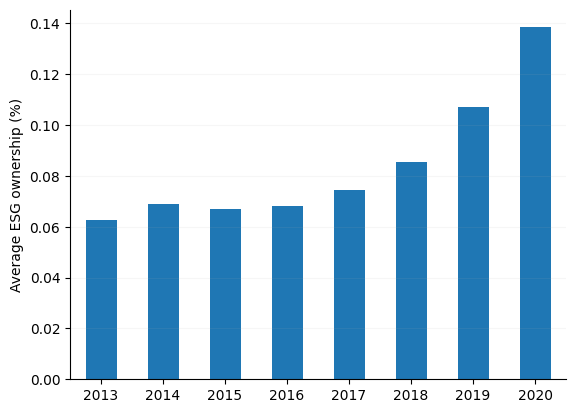

In [141]:
balanced_panel.groupby(balanced_panel.year_month.dt.year)['esg_ownership_percent'].mean().plot(kind='bar')
plt.ylabel("Average ESG ownership (%)")
plt.xlabel("")
plt.grid(axis='y', alpha=0.1)
plt.xticks(rotation=0)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('./refinitiv_results/mean_esg_ownership_overtime_ref.png', bbox_inches='tight');

In [142]:
balanced_panel.set_index('year_month').loc['2020-09-01'][['esg_ownership', 'total_esg_score']].corr()

,esg_ownership,total_esg_score
esg_ownership,1.000000,0.129117
total_esg_score,0.129117,1.000000


In [143]:
balanced_panel.set_index('year_month').loc['2020-09-01'][['esg_ownership', 'total_esg_score_normalized']].corr()

,esg_ownership,total_esg_score_normalized
esg_ownership,1.000000,0.129117
total_esg_score_normalized,0.129117,1.000000


### Change in numerical scores

In [144]:
one_index_before_upgrade = (balanced_panel[balanced_panel['upgrade_dummy']==1].index - 1).tolist()

In [145]:
upgrade_index = balanced_panel[balanced_panel['upgrade_dummy']==1].index.tolist()

In [146]:
upgrades_and_one_index_before = one_index_before_upgrade + upgrade_index

In [147]:
upgrades_and_one_index_before = pd.to_numeric(upgrades_and_one_index_before)

In [148]:
upgrades_and_one_index_before_table = balanced_panel.loc[upgrades_and_one_index_before].sort_index()

In [149]:
# upgrades_and_one_index_before_table

In [150]:
change_in_ratings_upgrades = upgrades_and_one_index_before_table['total_esg_score_normalized'] - upgrades_and_one_index_before_table['total_esg_score_normalized'].shift()

In [151]:
change_in_ratings_upgrades = change_in_ratings_upgrades.iloc[1::2]

In [152]:
#similarly for downgrades

In [153]:
one_index_before_downgrade = (balanced_panel[balanced_panel['downgrade_dummy']==1].index - 1).tolist()

In [154]:
downgrade_index = balanced_panel[balanced_panel['downgrade_dummy']==1].index.tolist()

In [155]:
downgrades_and_one_index_before = one_index_before_downgrade + downgrade_index

In [156]:
downgrades_and_one_index_before = pd.to_numeric(downgrades_and_one_index_before)

In [157]:
downgrades_and_one_index_before_table = balanced_panel.loc[downgrades_and_one_index_before].sort_index()

In [158]:
# downgrades_and_one_index_before_table

In [159]:
change_in_ratings_downgrades = downgrades_and_one_index_before_table['total_esg_score_normalized'] - downgrades_and_one_index_before_table['total_esg_score_normalized'].shift()

In [160]:
change_in_ratings_downgrades = change_in_ratings_downgrades.iloc[1::2]

In [161]:
change_in_ratings_both = pd.concat([change_in_ratings_downgrades, change_in_ratings_upgrades])

In [162]:
change_in_ratings_both

11     -0.795484
151    -1.630349
243    -0.177212
287    -1.685482
379    -1.241796
          ...   
4152    1.210291
4243    0.727225
4347    0.339984
4439    4.393542
4543    1.063271
Name: total_esg_score_normalized, Length: 100, dtype: float64

In [163]:
change_in_ratings_both.min()

-1.879758466789184

In [164]:
change_in_ratings_both.max()

4.393541611971647

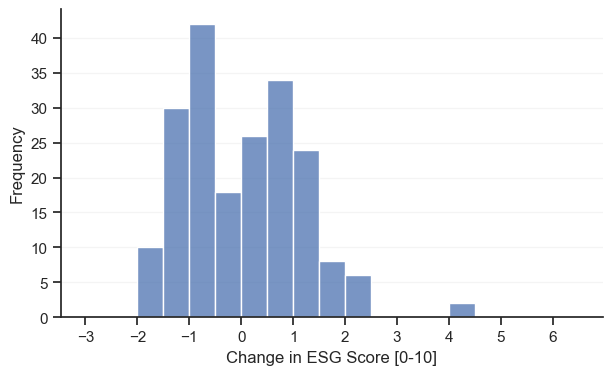

In [165]:
plt.figure(figsize=(7,4))
sns.set_theme(style="ticks")
hist = sns.histplot(change_in_ratings_both, stat='frequency', bins=np.arange(-3, 7, 0.5))
plt.xlabel('Change in ESG Score [0-10]')
sns.despine()
plt.xticks(np.arange(-3, 7, 1))
plt.grid(axis='y', alpha=0.2)
plt.savefig('./refinitiv_results/balanced_sample_refinitiv_change_ratings.png', bbox_inches='tight')

In [166]:
# bin edges
np.round([h.xy[0] for h in hist.patches],2)

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,
        2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ])

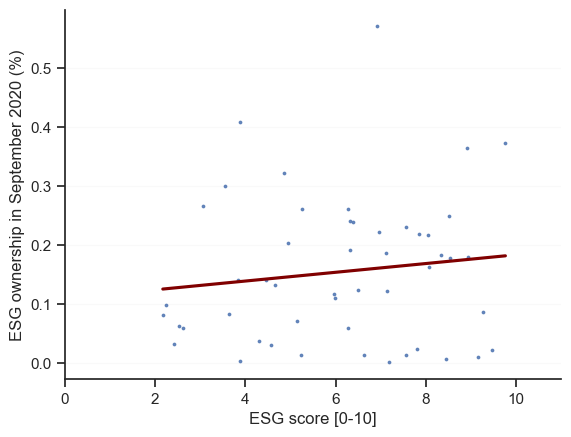

In [167]:
sns.regplot(data=balanced_panel.set_index('year_month').loc['2020-09-01'], 
            x='total_esg_score_normalized',
           y=balanced_panel.set_index('year_month').loc['2020-09-01']['esg_ownership_percent'],
           ci=None,
           line_kws={'color':'maroon'}, 
           scatter_kws={"s": 3})

plt.xlabel('ESG score [0-10]')
plt.ylabel('ESG ownership in September 2020 (%)')
plt.grid(axis='y', alpha=0.1)
plt.xlim(0,11)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('./refinitiv_results/corr_ref.png', bbox_inches='tight')

### Number of upgrades and downgrades

In [168]:
balanced_panel[(balanced_panel['upgrade_dummy']==1)|(balanced_panel['downgrade_dummy']==1)]

,ID,year_month,cusip,nbr_shares,total_esg_score,environment_score,social_score,governance_score,ShrOut,esg_grade,...,time_to_treatment_down_163,time_to_treatment_down_164,time_to_treatment_down_165,time_to_treatment_down_166,time_to_treatment_down_167,time_to_treatment_down_168,time_to_treatment_down_169,time_to_treatment_down_170,time_to_treatment_down_171,total_esg_score_normalized
11,94,2014-01-01,01449110,7515,30.84,34.24,50.17,8.73,43105.0,C-,...,0,0,0,0,0,0,0,0,0,2.410081
23,94,2015-01-01,01449110,9797,39.82,38.91,68.05,14.39,48755.0,C,...,0,0,0,0,0,0,0,0,0,3.588868
151,117,2018-01-01,02000210,300642,70.79,82.14,81.86,54.09,358826.0,B+,...,0,0,0,0,0,0,0,0,0,7.654240
163,117,2019-01-01,02000210,360327,76.53,79.19,78.22,73.68,344442.0,A-,...,0,0,0,0,0,0,0,0,0,8.407719
207,275,2015-01-01,05329W10,24278,40.19,0.00,40.45,59.99,113144.0,C,...,0,0,0,0,0,0,0,0,0,3.637438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,2780,2015-01-01,98978V10,724077,35.56,25.69,44.83,28.94,501325.0,C,...,0,0,0,0,0,0,0,0,0,3.029667
4439,2835,2015-01-01,G6518L10,369517,58.51,58.99,69.95,43.27,375717.0,B,...,0,0,0,0,0,0,0,0,0,6.042268
4451,2835,2016-01-01,G6518L10,108920,54.37,54.65,67.66,36.77,364058.0,B-,...,0,0,0,0,0,0,0,0,0,5.498819
4543,2872,2016-01-01,N5374510,284772,56.74,50.51,54.18,72.07,449444.0,B-,...,0,0,0,0,0,0,0,0,0,5.809924


In [169]:
balanced_panel[(balanced_panel['upgrade_dummy']==1)]

,ID,year_month,cusip,nbr_shares,total_esg_score,environment_score,social_score,governance_score,ShrOut,esg_grade,...,time_to_treatment_down_163,time_to_treatment_down_164,time_to_treatment_down_165,time_to_treatment_down_166,time_to_treatment_down_167,time_to_treatment_down_168,time_to_treatment_down_169,time_to_treatment_down_170,time_to_treatment_down_171,total_esg_score_normalized
23,94,2015-01-01,01449110,9797,39.82,38.91,68.05,14.39,48755.0,C,...,0,0,0,0,0,0,0,0,0,3.588868
163,117,2019-01-01,02000210,360327,76.53,79.19,78.22,73.68,344442.0,A-,...,0,0,0,0,0,0,0,0,0,8.407719
207,275,2015-01-01,05329W10,24278,40.19,0.00,40.45,59.99,113144.0,C,...,0,0,0,0,0,0,0,0,0,3.637438
299,303,2015-01-01,05534B76,35421,60.96,86.59,52.41,58.45,840330.0,B,...,0,0,0,0,0,0,0,0,0,6.363875
391,323,2015-01-01,06050510,3692318,68.49,92.73,70.60,57.49,10516450.0,B+,...,0,0,0,0,0,0,0,0,0,7.352323
529,328,2018-11-01,06414910,3377,80.57,94.46,92.48,58.60,1227059.0,A-,...,0,0,0,0,0,0,0,0,0,8.938041
587,332,2016-01-01,06652K10,21952,45.88,21.14,57.48,48.25,103626.0,C+,...,0,0,0,0,0,0,0,0,0,4.384353
719,390,2019-05-01,09367110,186050,31.82,11.95,24.80,65.34,203293.0,C-,...,0,0,0,0,0,0,0,0,0,2.538724
771,509,2016-01-01,13645T10,58680,53.29,50.35,55.02,54.56,152952.0,B-,...,0,0,0,0,0,0,0,0,0,5.357049
851,525,2015-01-01,14233910,84135,34.23,27.46,20.41,62.05,64166.0,C,...,0,0,0,0,0,0,0,0,0,2.855080


In [170]:
balanced_panel[(balanced_panel['downgrade_dummy']==1)]

,ID,year_month,cusip,nbr_shares,total_esg_score,environment_score,social_score,governance_score,ShrOut,esg_grade,...,time_to_treatment_down_163,time_to_treatment_down_164,time_to_treatment_down_165,time_to_treatment_down_166,time_to_treatment_down_167,time_to_treatment_down_168,time_to_treatment_down_169,time_to_treatment_down_170,time_to_treatment_down_171,total_esg_score_normalized
11,94,2014-01-01,01449110,7515,30.84,34.24,50.17,8.73,43105.0,C-,...,0,0,0,0,0,0,0,0,0,2.410081
151,117,2018-01-01,02000210,300642,70.79,82.14,81.86,54.09,358826.0,B+,...,0,0,0,0,0,0,0,0,0,7.654240
243,275,2018-01-01,05329W10,59746,49.50,0.00,43.54,80.88,91244.0,C+,...,0,0,0,0,0,0,0,0,0,4.859543
287,303,2014-01-01,05534B76,33136,57.56,82.86,56.23,40.83,775893.0,B-,...,0,0,0,0,0,0,0,0,0,5.917564
379,323,2014-01-01,06050510,6490692,58.88,92.26,68.07,34.21,10591808.0,B,...,0,0,0,0,0,0,0,0,0,6.090837
493,328,2015-11-01,06414910,72007,75.61,89.22,94.31,46.49,1203284.0,A-,...,0,0,0,0,0,0,0,0,0,8.286952
611,332,2018-01-01,06652K10,137569,49.81,3.85,57.37,57.76,106848.0,C+,...,0,0,0,0,0,0,0,0,0,4.900236
695,390,2017-05-01,09367110,44979,19.89,0.00,19.36,40.79,207167.0,D+,...,0,0,0,0,0,0,0,0,0,0.972696
747,509,2014-01-01,13645T10,45166,47.94,40.45,41.55,65.25,175225.0,C+,...,0,0,0,0,0,0,0,0,0,4.654765
839,525,2014-01-01,14233910,8347,33.31,26.14,23.35,55.65,63603.0,C-,...,0,0,0,0,0,0,0,0,0,2.734313


In [171]:
len(balanced_panel.cusip.drop_duplicates())

50

In [172]:
summary_statistcis_list = ['esg_ownership_percent', 'total_esg_score']

In [173]:
summary_statistics_table = balanced_panel.loc[:, summary_statistcis_list].describe().T.apply(lambda x: x.map('{:.2f}'.format))

In [174]:
summary_statistics_table = summary_statistics_table.rename(index={'esg_ownership_percent': 'ESG ownership (%)',
                                      'total_esg_score': 'ESG score [0-100]',
                                      'nbr_shares': 'Number of shares', 
                                      'ShrOut':'Shares outstanding'
                                                                 })

In [175]:
summary_statistics_table = summary_statistics_table.drop(columns=['min', 'max', '25%', '50%', '75%'])

In [176]:
summary_statistics_table

,count,mean,std
ESG ownership (%),4600.00,0.08,0.10
ESG score [0-100],4600.00,52.25,18.74


In [177]:
print(summary_statistics_table.to_latex())

\begin{tabular}{llll}
\toprule
{} &    count &   mean &    std \\
\midrule
ESG ownership (\%) &  4600.00 &   0.08 &   0.10 \\
ESG score [0-100] &  4600.00 &  52.25 &  18.74 \\
\bottomrule
\end{tabular}



C:\Users\johnd\AppData\Local\Temp\ipykernel_4204\2345313784.py:1: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



### Number of cohorts

In [178]:
len(balanced_panel['cohort_up'].drop_duplicates())

17

In [179]:
len(balanced_panel['cohort_down'].drop_duplicates())

15